# Load Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
plt.style.use('seaborn')

# Load Dataset

In [3]:
df=pd.read_csv('train.csv', index_col='Loan_ID')
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


terdapat 12 kolom dan 614 data. Hanya variabel ApplicantIncome, CoapplicantIncome, Education, Propoerty Area, dan Loan_Status yang tidak memiliki missing value. Hal tersebut mungkin dikarenakan pada formulir permintaan peminjaman tidak diisi oleh peminjam.

# Missing Value Imputation

In [5]:
pd.crosstab(df['Married'], (df['CoapplicantIncome']==0))

CoapplicantIncome,False,True
Married,,
No,70,143
Yes,270,128


Imputasi variabel married berdasarkan coappilant income. Diasumsikan hubungan Applicant dan Coapplicant adalah suami istri. Dari crosstable diatas dapat disimpulkan applicant yang belum menikah cenderung tidak memiliki coapplicant income dan sebaliknya.

In [6]:
df.loc[(df['Married'].isnull()) & (df['CoapplicantIncome']==0), 'Married'] = 'No'
df.loc[(df['Married'].isnull()), 'Married'] = 'Yes'

In [7]:
pd.crosstab(df['Gender'], (df['Married']=='Yes') & (df['ApplicantIncome']>df['CoapplicantIncome']))

col_0,False,True
Gender,,
Female,86,26
Male,180,309


In [8]:
import scipy.stats as scs
pvalue=scs.chi2_contingency(pd.crosstab(df['Gender'], (df['Married']=='Yes') & (df['ApplicantIncome']>df['CoapplicantIncome'])))[1]
print('p-value = ',pvalue)
if pvalue < 0.05:
    print('Ada Perbedaan')
else:
    print('Tidak Ada Perbedaan')

p-value =  3.519139852051623e-14
Ada Perbedaan


Diasumsikan jika applicant telah menikah dan pendapatannya lebih besar dari coapplicant maka gendernya adalah pria.

In [9]:
a=((df['Gender'].isnull()) & (df['Married']=='Yes') & (df['ApplicantIncome']>df['CoapplicantIncome']))
df.loc[a, 'Gender'] = 'Male'
df.loc[df['Gender'].isnull(),'Gender'] = 'Female'

Variabel lainnya dapat diimputasi dengan modus untuk variabel kualitatif dan mean untuk variabel kuantitatif. Berikut akan dilakukan imputasi dengan modus Gender,Married,Self_Employed,Dependents, dan Credit_History lalu imputasi dengan mean pada variabel LoanAmount,ApplicantIncome,CoapplicantIncome, dan Loan_Amount_Term.

In [10]:
mmodus = ['Gender','Married','Self_Employed','Dependents','Credit_History']
mmean = ['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term']

In [11]:
for feature in mmean:
        if feature in df.columns.values:
            df[feature] = df[feature].fillna(df[feature].mean())
            
for feature in mmodus:
        if feature in df.columns.values:
            df[feature] = df[feature].fillna(df[feature].value_counts().index[0])

# Data Exploration

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
Gender               614 non-null object
Married              614 non-null object
Dependents           614 non-null object
Education            614 non-null object
Self_Employed        614 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           614 non-null float64
Loan_Amount_Term     614 non-null float64
Credit_History       614 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


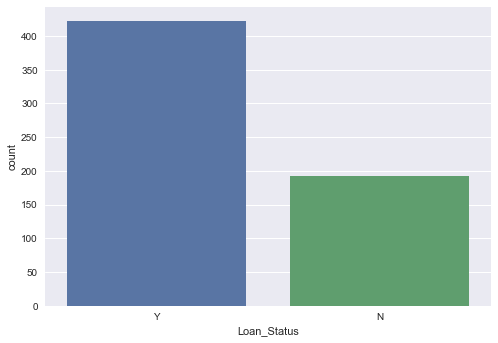

In [13]:
sns.countplot(x=df.Loan_Status)
plt.show()

Dari diagram batang diatas diketahui kelas data tidak seimbang, artinya para pelamar pinjaman kebanyakan memiliki kesempatan pinjamannya diterima oleh instansi terkait

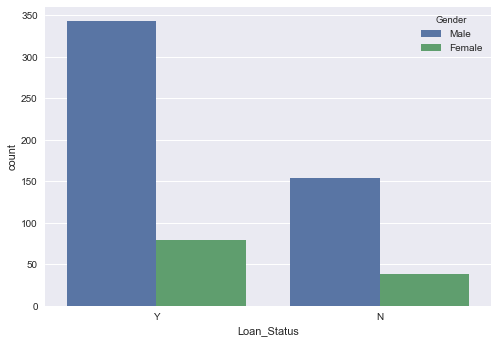

In [14]:
sns.countplot(hue="Gender", x='Loan_Status', data=df)
plt.show()

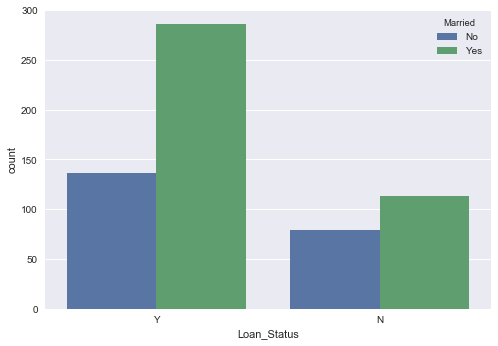

In [15]:
sns.countplot(hue="Married", x='Loan_Status', data=df)
plt.show()

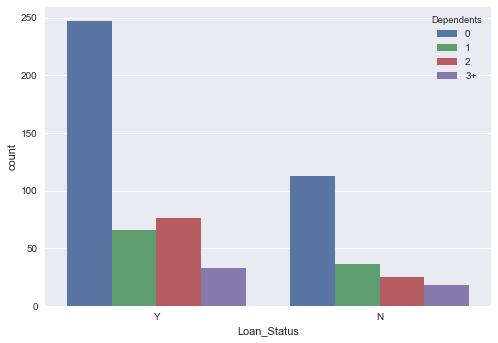

In [16]:
sns.countplot(hue="Dependents", x='Loan_Status', data=df)
plt.show()

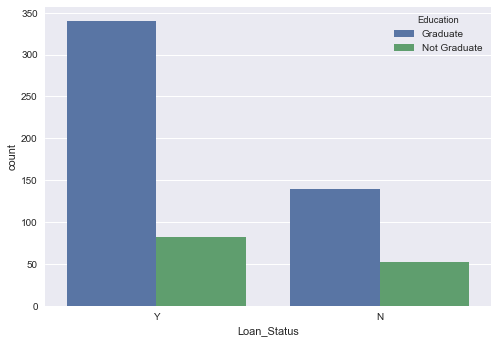

In [17]:
sns.countplot(hue="Education", x='Loan_Status', data=df)
plt.show()

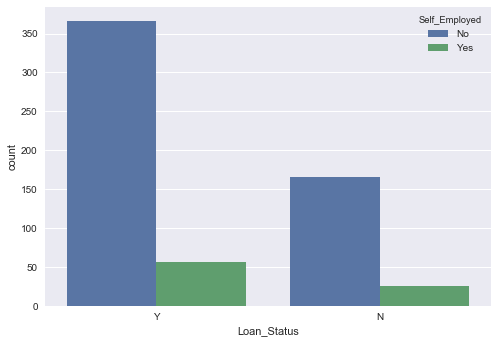

In [18]:
sns.countplot(hue="Self_Employed", x='Loan_Status', data=df)
plt.show()

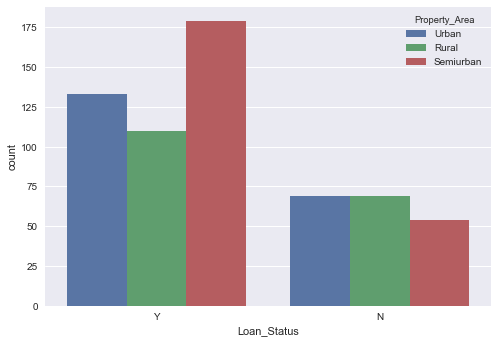

In [19]:
sns.countplot(hue="Property_Area", x='Loan_Status', data=df)
plt.show()

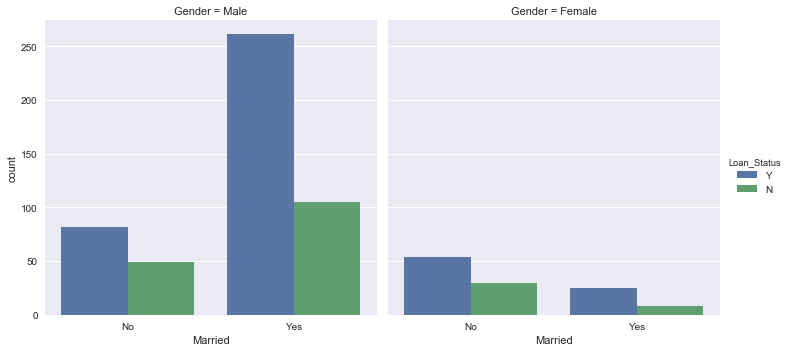

In [21]:
sns.catplot(x="Married", hue="Loan_Status", col="Gender",data=df, kind="count")
plt.show()

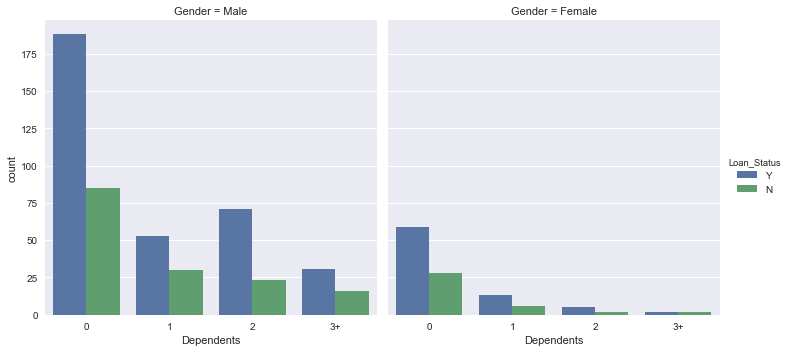

In [22]:
sns.catplot(x="Dependents", hue="Loan_Status", col="Gender",data=df, kind="count")
plt.show()

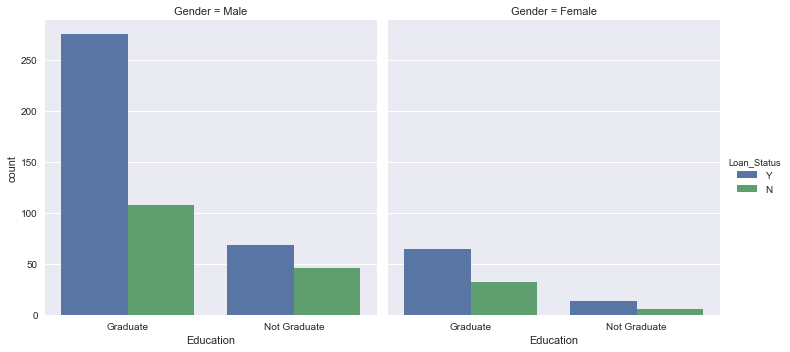

In [23]:
sns.catplot(x="Education", hue="Loan_Status", col="Gender",data=df, kind="count")
plt.show()

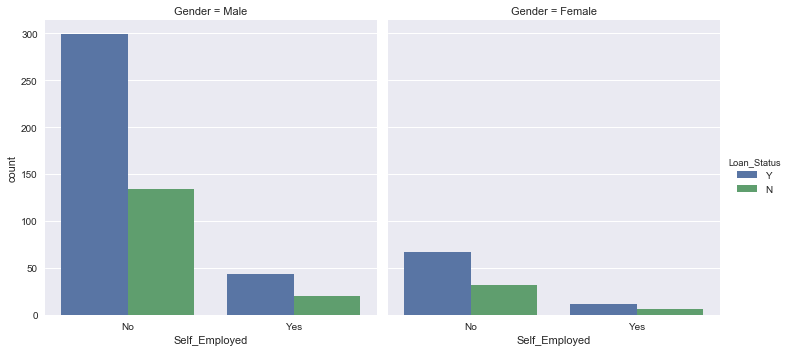

In [24]:
sns.catplot(x="Self_Employed", hue="Loan_Status", col="Gender",data=df, kind="count")
plt.show()

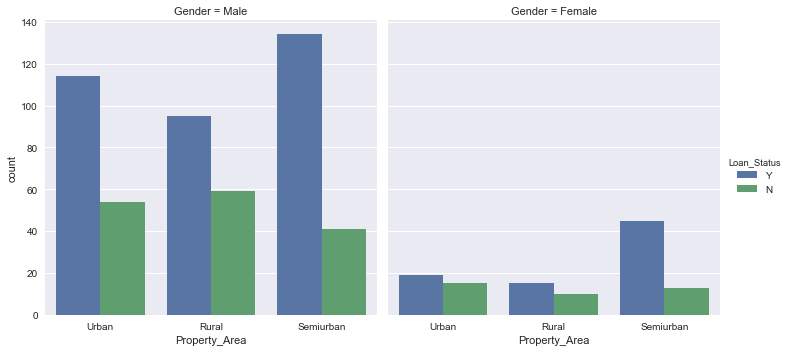

In [25]:
sns.catplot(x="Property_Area", hue="Loan_Status", col="Gender",data=df, kind="count")
plt.show()

## Encoding Categorical Features

In [53]:
kategori = ['Gender','Married','Education','Self_Employed','Dependents','Credit_History', 'Property_Area','Loan_Status']
for feature in kategori:
        if feature in df.columns.values:
            df[feature] = LabelEncoder().fit_transform(df[feature])

In [54]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1,2,1
LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1,0,0
LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1,2,1
LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1,2,1
LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1,2,1


In [57]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
Gender               614 non-null int32
Married              614 non-null int32
Dependents           614 non-null int32
Education            614 non-null int32
Self_Employed        614 non-null int32
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           614 non-null float64
Loan_Amount_Term     614 non-null float64
Credit_History       614 non-null int64
Property_Area        614 non-null int32
Loan_Status          614 non-null int32
dtypes: float64(3), int32(7), int64(2)
memory usage: 65.6+ KB
None


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1,2,1
LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1,0,0
LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1,2,1
LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1,2,1
LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1,2,1


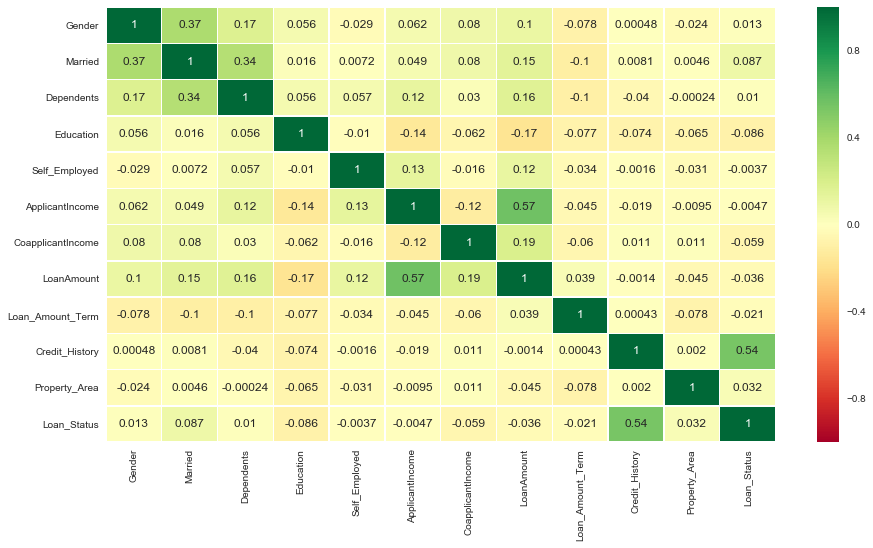

In [56]:
sns.heatmap(df.corr(),linewidths=.5,annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

Diatas merupakan hubungan antar variabel menggunakan heatmap. Semakin berwarna hijau hubungan variabel semakin tinggi dengan memiliki hubungan yang berbanding lurus, sedangkan semakin berwarna merah hubungan variabel tinggi namun memiliki hubungan yang berbanding terbalik. Hanya variabel Credit_history yang memiliki korelasi cukup besar terhadap Loan_Status dengan hubungan yang berbanding lurus. Artinya Credit_history dan Loan_Status memiliki hubungan yang cukup tinggi.

C:\Users\user\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


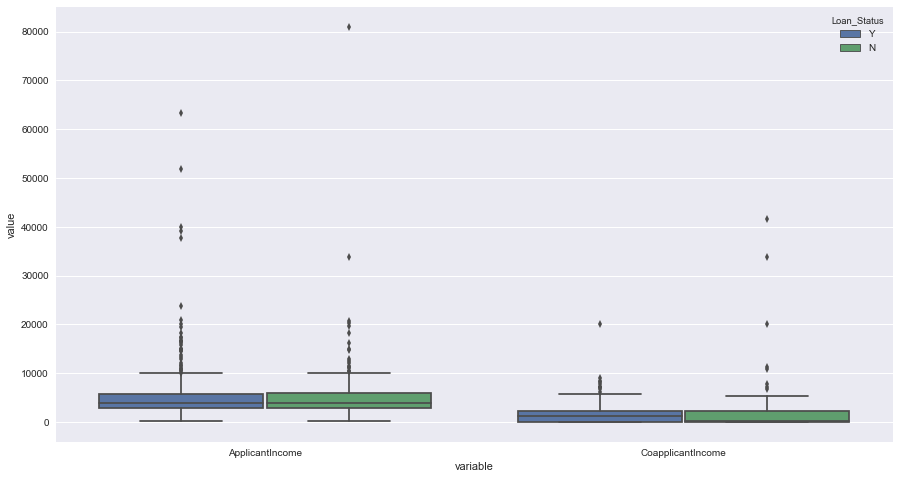

In [52]:
dff=pd.melt(df[['ApplicantIncome','CoapplicantIncome','Loan_Status']],id_vars='Loan_Status')
sns.boxplot(y="value", x="variable", hue='Loan_Status', data=dff)
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

Gambar diatas merupakan pembanding ApplicantIncome dan CoapplicantIncome berdasarkan Loan_Status. Variabel ApplicantIncome dan CoapplicantIncome tidak memiliki perbedaan karakteristik terhadap Loan Status terlihat bahwa gambar diatas memiliki karakteristik yang sama.

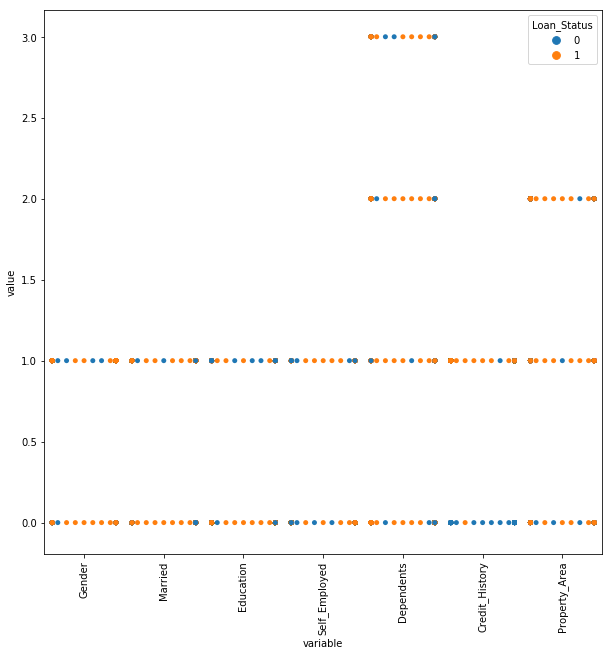

In [130]:
dff2=pd.melt(df[['Gender','Married','Education','Self_Employed','Dependents','Credit_History', 'Property_Area','Loan_Status']],id_vars='Loan_Status')
sns.swarmplot(x="variable", y="value", hue="Loan_Status", data=dff2)
plt.xticks(rotation=90)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Hanya variabel Credit_History yang memiliki perbedaan karakteristik terhadap Loan Status. Terlihat ketika membuat kelompok antara nilai pada tiap variabel dapat membedakan Loan_Status.

# Feature Engineering

In [131]:
df['TotalIncome']=df['ApplicantIncome']+df['CoapplicantIncome']
df['Loan/Income']=df['LoanAmount']/df['TotalIncome']
df['Loan/Term']=df['LoanAmount']/df['Loan_Amount_Term']
df['RepaymentRatio']=(df['Loan/Term']*1000)/df['TotalIncome']

In [132]:
transformation=StandardScaler().fit(df[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']])
df[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']]=transformation.transform(df[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']])

In [133]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,Loan/Income,Loan/Term,RepaymentRatio
Loan_ID,,,,,,,,,,,,,,,,
LP001002,1,0,0,0,0,0.072991,-0.554487,0.000000,0.279851,1,2,1,-0.182184,0.025032,0.406700,0.069533
LP001003,1,1,1,0,0,-0.134412,-0.038732,-0.219273,0.279851,1,0,0,-0.144684,0.021015,0.355556,0.058374
LP001005,1,1,0,0,1,-0.393747,-0.554487,-0.957641,0.279851,1,2,1,-0.623656,0.022000,0.183333,0.061111
LP001006,1,1,0,1,0,-0.462062,0.251980,-0.314547,0.279851,1,2,1,-0.322885,0.024287,0.333333,0.067463
LP001008,1,0,0,0,0,0.097728,-0.554487,-0.064454,0.279851,1,2,1,-0.158785,0.023500,0.391667,0.065278


Penambahan variabel yang dibuat berdasarkan variabel yang sudah ada dapat digunakan untuk meningkatkan nilai prediksi pada model yang akan dibangun. Sehingga didapatkan 4 variabel baru yang diduga dapat meningkatkan model prediksi yaitu variabel TotalIncome,Loan/Income,Loan/Term dan RepaymentRatio.

In [134]:
x=df.drop('Loan_Status', axis=1)
y=df['Loan_Status']

# Classification Algorithm

In [135]:
cv=StratifiedKFold(n_splits=5,random_state=5)

In [136]:
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Bagging', BaggingClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('MLP', MLPClassifier ( max_iter=1000)))

results = []
names = []
tabel=[]
for name, model in models:
    akurasi=cross_val_score(model, x, y,cv=cv)
    results.append(akurasi)
    names.append(name)
    hasil = "%s: %f" % (name, akurasi.mean())
    tabel.append(hasil)
tabel

['CART: 0.708778',
 'KNN: 0.744474',
 'Naive Bayes: 0.794897',
 'SVM: 0.801401',
 'Random Forest: 0.767187',
 'Bagging: 0.778583',
 'AdaBoost: 0.793178',
 'Gradient Boosting: 0.788498',
 'Logistic Regression: 0.804680',
 'MLP: 0.778556']

Pembangunan model berdasarkan metode tersebut dihasilkan bahwa Regresi Logistik memiliki nilai prediksi yang tinggi sehingga pada kasus ini digunakan metode Regresi Logistik dimana metode ini dapat membedakan Loan_Status dengan benar paling tinggi pada metode-metode diatas.

## Prediction

Berikut merupakan suatu database baru, dimana database ini digunakan untuk menentukan apakah pelamar pinjaman akan diterima atau tidak pengajuan pinjaman pada instansi ini. Dengan perlakuan yang sama pada database diatas maka harus terdapat penambahan variabel yang dibentuk yang terlebih dahulu harus mengatasi missing value dengan cara sama.

In [137]:
df_test=pd.read_csv('test.csv',index_col='Loan_ID')
df_test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [138]:
#Imputasi missing value
df_test.loc[(df_test['Married'].isnull()) & (df_test['CoapplicantIncome']==0), 'Married'] = 'No'
df_test.loc[(df_test['Married'].isnull()), 'Married'] = 'Yes'

a=((df_test['Gender'].isnull()) & (df_test['Married']=='Yes') & (df_test['ApplicantIncome']>df_test['CoapplicantIncome']))
df_test.loc[a, 'Gender'] = 'Male'
df_test.loc[df_test['Gender'].isnull(),'Gender'] = 'Female'

mmodus = ['Gender','Married','Self_Employed','Dependents','Credit_History']
mmedian = ['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term']

for feature in mmedian:
        if feature in df_test.columns.values:
            df_test[feature] = df_test[feature].fillna(df_test[feature].mean())
            
for feature in mmodus:
        if feature in df_test.columns.values:
            df_test[feature] = df_test[feature].fillna(df_test[feature].value_counts().index[0])
#Variabel Kategori
kategori = ['Gender','Married','Education','Self_Employed','Dependents','Credit_History', 'Property_Area','Loan_Status']

for feature in kategori:
        if feature in df_test.columns.values:
            df_test[feature] = LabelEncoder().fit_transform(df_test[feature])

#Feature Engineering
df_test['TotalIncome']=df_test['ApplicantIncome']+df_test['CoapplicantIncome']
df_test['Loan/Income']=df_test['LoanAmount']/df_test['TotalIncome']
df_test['Loan/Term']=df_test['LoanAmount']/df_test['Loan_Amount_Term']
df_test['RepaymentRatio']=(df_test['Loan/Term']*1000)/df_test['TotalIncome']

#transformasi
transformation=StandardScaler().fit(df_test[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']])
df_test[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']]=transformation.transform(df_test[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']])

In [139]:
model=LogisticRegression(class_weight='balanced')
cross_val_score(model, x, y,cv=cv).mean()

0.77527763088313073

In [140]:
model.fit(x,y)
y_predict=model.predict(df_test)
y_predict

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1,

In [141]:
y_predict=pd.DataFrame(y_predict,columns =['Loan_Status'],index=df_test.index)
y_predict['Loan_Status']= y_predict['Loan_Status'].map({1: 'Y', 0: 'N'})
y_predict.to_csv("Submission.csv")
y_predict.head()

,Loan_Status
Loan_ID,
LP001015,Y
LP001022,Y
LP001031,Y
LP001035,Y
LP001051,Y


Diatas merupakan hasil dari model regresi logistik dengan database baru untuk menentukan apakah pengajuan pinjaman diterima ataupun tidak. Dari hasil analisis berdasarkan data diatas diketahui bahwa nilai Credit_History merupakan faktor yang berpengaruh besar untuk menentukan apakah pengajuan pinjaman diterima atau tidak.